## Analysing Buyer Behaviour Using Consumer Panel Data

### Introduction

Several leading market research firms (e.g., Kantar, IRI, Nielsen) collect so called consumer panel data and sell reports and analyses based on these data to interested parties. A large number of households are recruited to join the panel and they record all their grocery/HBA purchases. The idea of a panel is that we have repeated observations of the same people. The ability to track what individual households are purchasing over time can give important insights into what behavioural changes lie beneath observed changes in aggregate sales data. (terms panellist and household are used interchangeably) Nowadays, it is common for panellists to record their purchasing by scanning product barcodes via an app on their smartphones.

The objective of this notebook is to provide an introduction to basic analyses we can undertake using panel data. After briefing **describing the data** we will be working with, we present some preliminary **aggregate-level analyses**. Next we introduce some basic **brand performance measures** and consider the simple analyses that describe the **variation we observe in buyer behaviour** in a given time period. This analysis focuses on one brand at a time; next we consider some basic analyses that describe consumers’ **buying of multiple brands in a category**. We finish with some basic analyses that describe **how buyer behaviour evolves over time**, both for established products and new products.

Note: Whereas consumer panel data gives us information on the purchasing of a sample of customers for the whole category, the data in a firm’s transaction database gives us complete information on the purchasing of our products (but not those of our competitors). At a fundamental level, the types of reports developed by market research firms over the past 60+ years are a good starting point for the types of reports a firm should create as it seeks to understand the buying behaviour of its customers.

A traditional consumer panel works in the following manner.
1) When an individual first joins the panel, they complete a detailed questionnaire. A section of this questionnaire focuses on the demographics of their household. (This is typically updated once a year.)
2) After each shopping trip, each panellist records their purchases, scanning the barcode associated with each product and recording other information such as where the purchase was made (store or channel), the price paid, and the use of promotional deals. Twenty years ago, this would have been done using a custom handheld barcode scanner provided by the market research firm. These days, it is more common to use a smartphone app.
3) These data are uploaded to the research firm’s servers and merged with the purchases records of the other panellists. Each barcode is matched with detailed product information (e.g., category, brand, size, flavour) and this information is also stored in the database. The analyst can then create (typically product-category-specific) datasets for further analysis that tell us what each panellist purchased, when and where, and associated transaction- and/or product-specific data that may be of interest.
4) Panellists drop out of the panel all the time, and the research firm will be recruiting replacement households on a regular basis. When creating a dataset for further analysis, it is generally desirable to work with a so-called static sample of panellists, which comprises all those panellists active using the time period of interest; new panellists, as well as those that dropped out during the given time period, are excluded.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

#### Import Panel Data

We will make use of two datasets as we explore the basic types of summaries of buyer behaviour that can be created using consumer panel data. The first contains data on the purchasing of established brands in a mature product category, while the second contains data on the purchasing of a new product. Both datasets were created using static samples. While these are small datasets and contain a subset of the information available in the research firm’s databases, they are more than sufficient to convey the logic of creating the key summaries of buyer behaviour. Neither dataset includes data on the demographics of each panellist. As such, we will not consider how to create reports that explore how behaviours differ across demographic groups (e.g., by age or geography). However, anyone comfortable with the analyses undertaken in this note should be able to work out how to create such reports for themselves.

**Dataset 1**

The file `edible_grocery.csv` contains two years of data from a panel of 5021 households on their purchasing in an unnamed edible grocery product category. (We intentionally do not identity the category and the associated brand names.) There are 119 SKUs in this category. 91 SKUs are associated with the four largest brands in the category, which we have named Alpha, Bravo, Charlie, and Delta. The remaining SKUs belong to very low-share brands and we grouped them under the brand Other.

*Note*: SKU - A stock-keeping unit (SKU) is a unique combination of the attributes (e.g., brand, package type, package size, flavour) that define the products in the category.

Each record in this file consists of seven fields:
- `panel_id` A unique identifier for each household.
- `trans_id` A unique identifier for the purchase occasion.
- `week` The week number in which the purchase occurred. Week 1 corresponds to the calendar week starting on January 1, 20xy. Week 53 corresponds to the calendar week starting on December 31, 20xy.
- `sku_id` The SKU code.
- `units` The number of units purchased on the particular purchase occasion.
- `price` The price per unit paid at the point of purchase.
- `brand` The brand associated with the SKU purchased.

The associated file `sku_weight.csv` gives us the weight (in grams) of each SKU. There are two fields: `sku_id` and `weight`.

In [2]:
grocery_df = pd.read_csv("data/panel-datasets/edible_grocery.csv", 
                 header=0, 
                 delimiter=",", 
                 usecols=['panel_id','trans_id','week','sku_id','units','price','brand'],
                 dtype={'panel_id': 'int32',
                        'trans_id': 'int32',
                        'week': 'int16',
                        'sku_id': 'category',
                        'units': 'int16',
                        'price': 'float32',
                        'brand': 'category'})
grocery_df.head()

,panel_id,trans_id,week,sku_id,units,price,brand
0,3102011,1569,6,19,1,2.79,Alpha
1,3102012,4301,15,15,1,3.19,Alpha
2,3102012,4301,15,15,1,3.19,Alpha
3,3102012,4301,15,38,1,3.49,Bravo
4,3102012,4301,15,44,1,3.49,Bravo


In [3]:
sku_df = pd.read_csv("data/panel-datasets/sku_weight.csv", 
                 header=0, 
                 delimiter=",", 
                 usecols=['sku_id','weight'],
                 dtype={'sku_id': 'category',
                        'weight': 'int16'})
sku_df.head()

,sku_id,weight
0,1,400
1,2,400
2,3,400
3,4,250
4,5,1000


**Dataset 2**

“Kiwi Bubbles” is a masked name for a shelf-stable juice drink, aimed primarily at children, which is sold as a multipack with several single-serve containers bundled together. Prior to national launch, it underwent a year-long test conducted in two of IRI’s BehaviorScan markets. The file `kiwibubbles_trans.csv` contains purchasing data for the new product, drawn from 1300 panellists in Market 1 and 1499 panellists in Market 2. (The purchasing of other brands in the category has been excluded from the dataset.)

Each record in this file consists of five fields:
- `ID` A unique identifier for each household.
- `Market` 1 or 2.
- `Week` The week in which the purchase occurred.
- `Day` The day of the week in which the purchase occurred. (The product was launched on day 1 of week 1.)
- `Units` The number of units of the new product
purchased on the particular purchase occasion.

In [4]:
kiwi_df = pd.read_csv("data/panel-datasets/kiwibubbles_trans.csv", 
                 header=0, 
                 delimiter=",", 
                 usecols=['ID','Market','Week','Day','Units'],
                 dtype={'ID': 'int16',
                        'Market': 'category',
                        'Week': 'int16',
                        'Day': 'int16',
                        'Units': 'int16'})
kiwi_df.head()

,ID,Market,Week,Day,Units
0,10001,1,19,3,1
1,10002,1,12,5,1
2,10003,1,37,7,1
3,10004,1,30,6,1
4,10004,1,47,3,1


#### Reusable Functions

In [5]:
def style_series(series, format_type='float', caption='', header_name='Value', df=False):
    """
    Styles a pandas Series or DataFrame with customizable formatting, caption, table styling, and header name.

    Parameters:
    - series (pd.Series or pd.DataFrame): The Series or DataFrame to style.
    - format_type (str or list): 
        - If a string, it applies the same formatting to all columns ('pct', 'float', or 'int').
        - If a list, each string in the list corresponds to a format for the respective column.
                         'pct' for percentage formatting with 1 decimal precision,
                         'float' for float formatting with 2 decimal precision.
                         'int' for integer formatting with no decimals.        
    - caption (str): The caption for the styled DataFrame.
    - header_name (str): The name for the column header in the styled DataFrame.
    - df (bool): If True, treats the input as a DataFrame and skips conversion from Series.

    Returns:
    - pd.io.formats.style.Styler: A styled DataFrame representation of the Series.
    """
    # Convert Series to DataFrame for styling, using header_name for the column label
    df = series.to_frame(header_name) if not df else series

    # Handle case where format_type is a single string or a list
    if isinstance(format_type, str):
        # If it's a string, apply the same format to all columns
        format_type = [format_type] * df.shape[1]
    elif isinstance(format_type, list) and len(format_type) != df.shape[1]:
        raise ValueError("If format_type is a list, it must have the same length as the number of columns.")

    # Define the format string for each type
    format_dict = {}
    for i, col in enumerate(df.columns):
        if format_type[i] == 'pct':
            format_dict[col] = "{:.1%}"  # Percentage format with 1 decimal place
        elif format_type[i] == 'float':
            format_dict[col] = "{:,.2f}"  # Float format with 2 decimal places
        elif format_type[i] == 'int':
            format_dict[col] = "{:,.0f}"  # Integer format with no decimal places
        else:
            raise ValueError(f"Invalid format_type '{format_type[i]}'. Use 'pct', 'float', or 'int'.")

    # Apply styles
    styled_df = (
        df.style
        .set_caption(caption)
        .format(format_dict)
        .set_table_styles(
            [
                # Align caption to the left & add padding
                {
                    'selector': 'caption',
                    'props': [('caption-side', 'top'), ('text-align', 'left'), ('font-size', '1.2em'), ('font-weight', 'bold'), 
                              ('padding', "0.5em 0em"), ('white-space', 'nowrap')]
                },            
                # Style the header
                {
                    'selector': 'thead th',
                    'props': [('background-color', 'darkblue'), ('color', 'white'), ('font-size', '1.1em')]
                },
                # Increase column width
                {
                    'selector': 'td, th',
                    'props': [('min-width', '100px')]
                },
                # Hover effect for rows
                {
                    'selector': 'tr:hover',
                    'props': [('font-size', '1.25em')]
                }
            ],
            overwrite=False
        )
    )
    return styled_df

### Preliminaries

#### Weekly Sales Pattern

In [6]:
grocery_df['spend'] = grocery_df['units'] * grocery_df['price']
grouped_spend = grocery_df.pivot_table(index=['week'], 
                                       columns=['brand'], 
                                       values=['spend'], 
                                       aggfunc='sum',
                                       margins=True, 
                                       observed=True)
grouped_spend

spend                                                       \
brand         Alpha         Bravo      Charlie        Delta        Other   
week                                                                       
1        331.459991    247.779999    51.790001    17.639999    18.750000   
2        567.250000    398.640015    45.430000    34.189999    23.230000   
3        497.970001    639.979980    51.110001    39.389999    14.550000   
4       1389.959961    472.500000    51.869999    85.040001    39.779999   
5        358.239990    252.540009    40.209999    69.540001    45.930000   
...             ...           ...          ...          ...          ...   
101      265.769989    264.660004    64.029999    35.049999    26.880001   
102      379.610016    456.789978    43.500000    20.400000    43.610001   
103      532.500000    441.000000    76.400002    40.439999    45.549999   
104      394.890015    233.190002    53.180000    68.260002    36.680000   
All    68821.687500  55530.218750  9043.549805  6092.319824  3275.050049   

                      
brand            All  
week                  
1         667.419983  
2        1068.739990  
3        1243.000000  
4        2039.150024  
5         766.460022  
...              ...  
101       656.390015  
102       943.909973  
103      1135.890015  
104       786.200012  
All    142762.828125  

[105 rows x 6 columns]

In [7]:
from matplotlib.ticker import MultipleLocator

def sales_plot(col, title):
    plt.figure(figsize=(10,4))
    plt.plot(grouped_spend[grouped_spend.index != 'All']['spend', col], 'k', lw=1)
    plt.gca().yaxis.set_major_formatter('${x:,.0f}')
    plt.grid(axis='y', lw=0.5, linestyle="--")
    plt.gca().xaxis.set_major_locator(MultipleLocator(base=13))
    plt.xlabel('Week')
    plt.ylabel('Total Spend')
    plt.title(title)
    plt.tight_layout()
    plt.show()

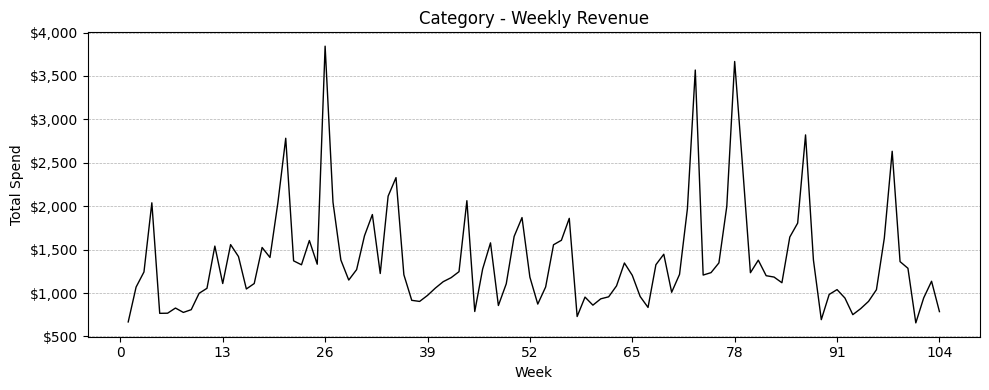

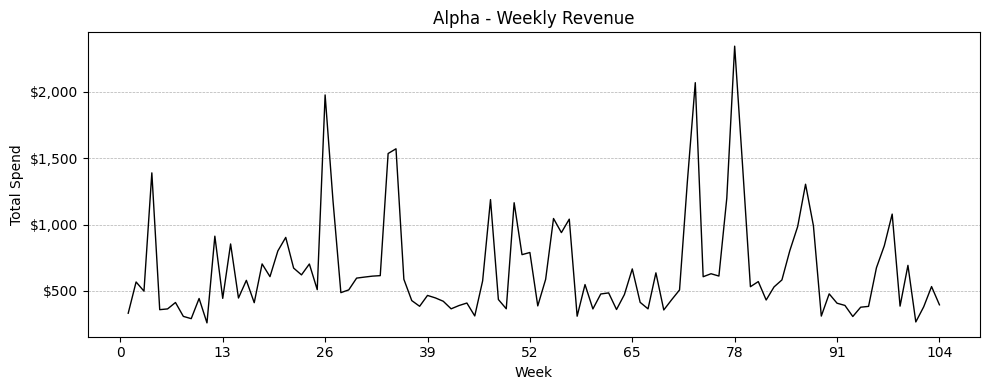

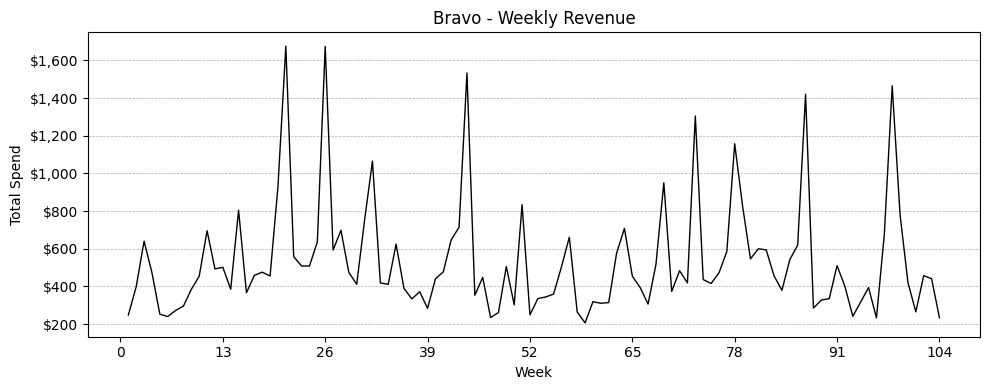

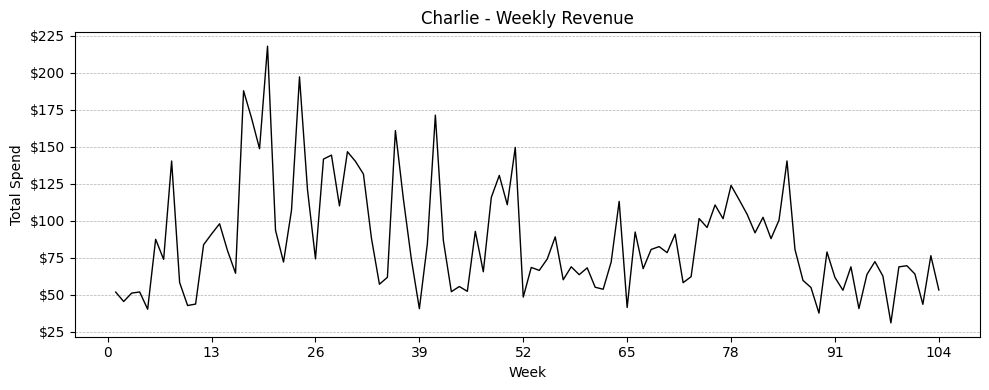

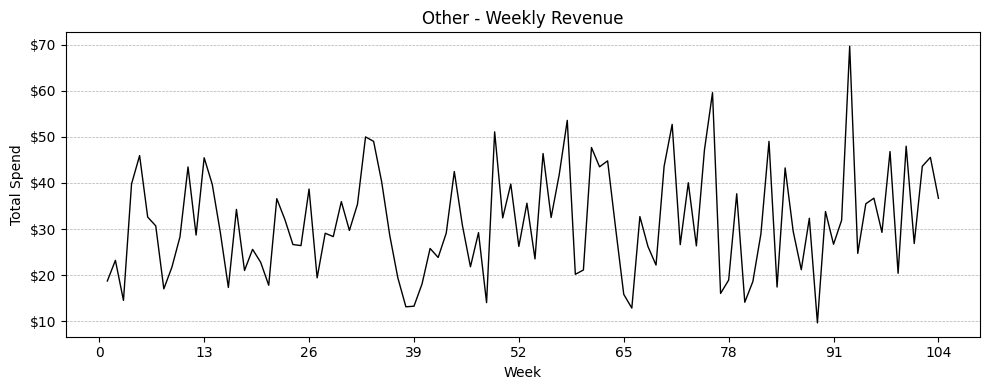

In [8]:
# Plot of weekly category revenue
sales_plot('All', 'Category - Weekly Revenue')
# Plot of weekly revenue for all brands
sales_plot('Alpha', 'Alpha - Weekly Revenue')
sales_plot('Bravo', 'Bravo - Weekly Revenue')
sales_plot('Charlie', 'Charlie - Weekly Revenue')
sales_plot('Other', 'Other - Weekly Revenue')

#### Weekly (Volume) Market Share

In [9]:
# Merge sku_df and grocery_df and convert grams to kg
grocery_df = grocery_df.merge(sku_df, left_on='sku_id', right_on='sku_id')
grocery_df['volume'] = (grocery_df['weight'] * grocery_df['units'])/1000 # weight from grams to kilograms

In [10]:
# Weekly (volume) market share
grouped_volume = grocery_df.groupby(['brand','week'], observed=True)['volume'].sum()
pct_volume = grouped_volume / grouped_volume.groupby(level=1, observed=True).transform('sum')
pct_volume.unstack(level=0)

brand,Alpha,Bravo,Charlie,Delta,Other
week,,,,,
1,0.481077,0.355011,0.111940,0.025320,0.026652
2,0.524953,0.371525,0.059391,0.029696,0.014435
3,0.389338,0.508812,0.060676,0.032505,0.008668
4,0.677032,0.230511,0.036686,0.044984,0.010787
5,0.428735,0.324306,0.075740,0.119348,0.051871
...,...,...,...,...,...
100,0.545707,0.317110,0.080381,0.039087,0.017715
101,0.368910,0.405520,0.140805,0.059138,0.025627
102,0.342581,0.543494,0.071147,0.019689,0.023089


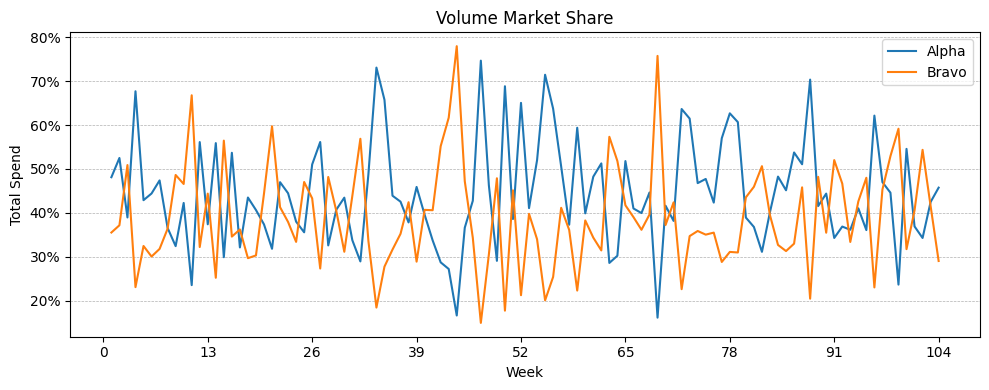

In [11]:
# Plot of weekly (volume) market share - Alpha & Bravo
plt.figure(figsize=(10,4))
plt.plot(pct_volume['Alpha'], label='Alpha')
plt.plot(pct_volume['Bravo'], label='Bravo')
plt.gca().yaxis.set_major_formatter('{x:,.0%}')
plt.grid(axis='y', lw=0.5, linestyle="--")
plt.gca().xaxis.set_major_locator(MultipleLocator(base=13))
plt.xlabel('Week')
plt.ylabel('Total Spend')
plt.title('Volume Market Share')
plt.legend()
plt.tight_layout()
plt.show()

There appears to be a **high level of competition** between these two brands. What is the correlation in their market shares?

We observe that there is a strong negative correlation between the shares of Alpha and Bravo: an increase in one brand’s share is associated with a corresponding decrease in the share of the other brand.

In [12]:
pct_volume.unstack(level=0).corr()

brand,Alpha,Bravo,Charlie,Delta,Other
brand,,,,,
Alpha,1.000000,-0.853061,-0.341580,-0.109693,-0.148193
Bravo,-0.853061,1.000000,-0.114179,-0.231641,-0.104983
Charlie,-0.341580,-0.114179,1.000000,0.131988,0.243434
Delta,-0.109693,-0.231641,0.131988,1.000000,0.308354
Other,-0.148193,-0.104983,0.243434,0.308354,1.000000


#### Annual Sales

In [13]:
# Annual sales by brand
grocery_df['year'] = np.ceil(grocery_df['week']/52).astype('int32')
group_year = grocery_df.groupby([grocery_df['year'], grocery_df['brand']], observed=True)['spend'].sum()
yearly_sales = group_year.unstack()
style_series(yearly_sales, format_type='float', caption='Annual sales ($)', df=True)

brand,Alpha,Bravo,Charlie,Delta,Other
year,,,,,
1,"33,570.94","28,603.35","5,120.87","3,271.51","1,535.23"
2,"35,250.75","26,926.87","3,922.68","2,820.81","1,739.82"


In [14]:
# Percentage change in annual sales by brand
yearly_sales.pct_change().T[2]
style_series(yearly_sales.pct_change().T[2], format_type='pct', caption='Percentage change in annual sales', header_name='% Change')

,% Change
brand,
Alpha,5.0%
Bravo,-5.9%
Charlie,-23.4%
Delta,-13.8%
Other,13.3%


In [15]:
# Annual category sales
yearly_sales.T.sum()
style_series(yearly_sales.T.sum(), format_type='float', caption='Annual Category Sales', header_name='Sales ($)')

,Sales ($)
year,
1,"72,101.89"
2,"70,660.93"


In [16]:
# Percentage change in category sales
yearly_sales.T.sum().pct_change().T[2]

-0.01998508

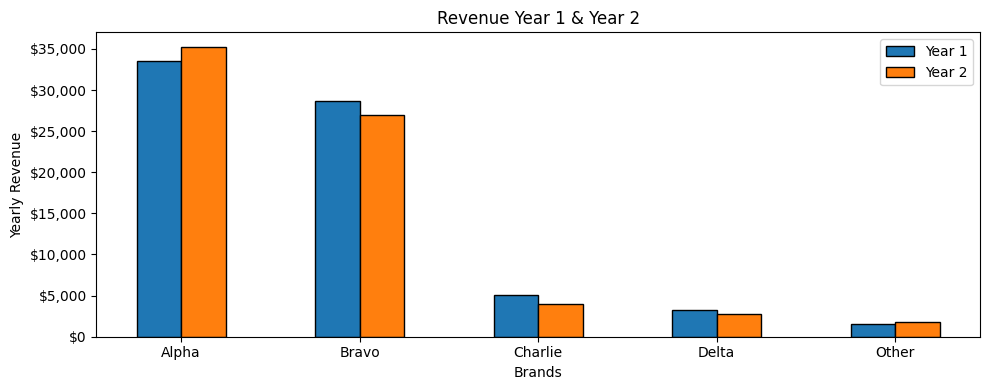

In [17]:
n = 5
r = np.arange(n)
width = 0.25

plt.figure(figsize=(10,4))
plt.bar(r, yearly_sales.T[1], width = width, edgecolor = 'black', label='Year 1')
plt.bar(r + width, yearly_sales.T[2], width = width, edgecolor = 'black', label='Year 2')
plt.xticks(r + width/2,yearly_sales.columns.values.tolist()) 
plt.gca().yaxis.set_major_formatter('${x:,.0f}')
plt.xlabel('Brands')
plt.ylabel('Yearly Revenue')
plt.title('Revenue Year 1 & Year 2')
plt.legend() 
plt.tight_layout()
plt.show()

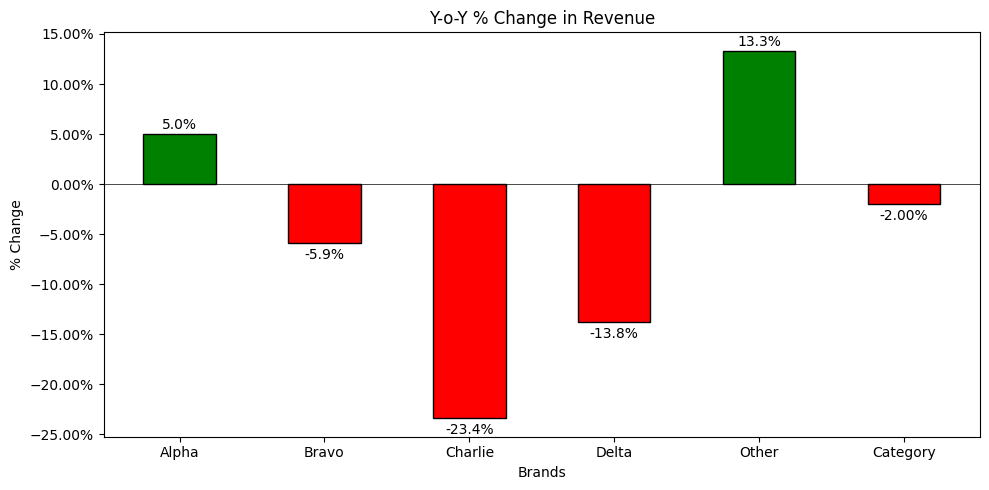

In [18]:
yoy_pct_change = yearly_sales.pct_change().T[2]
category_pct_change = yearly_sales.T.sum().pct_change().T[2]
axis_labels = yearly_sales.columns.values.tolist()
axis_labels.append('Category')

n = 5
r = np.arange(n+1)
width = 0.5

plt.figure(figsize=(10,5))

for i, val in enumerate(yoy_pct_change):
    color = 'green' if val > 0 else 'red'
    plt.bar(r[i], val, width=width, color=color, edgecolor = 'black')
    plt.text(r[i], val + 0.002 if val > 0 else val - 0.005, 
             f"{val:.1%}", ha='center', va='bottom' if val > 0 else 'top', color='black')
    
plt.bar(r[-1], category_pct_change, color='red', width=width, edgecolor = 'black')
plt.text(r[-1], category_pct_change - 0.005, f"{category_pct_change:.2%}", ha='center', va='top', color='black')
plt.xticks(r,axis_labels) 
plt.gca().yaxis.set_major_formatter('{x:,.2%}')
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Brands')
plt.ylabel('% Change')
plt.title('Y-o-Y % Change in Revenue')
plt.tight_layout()
plt.show()

#### Annual Market Share

In [19]:
market_share = group_year.div(group_year.unstack(level=0).sum()).unstack()
market_share

brand,Alpha,Bravo,Charlie,Delta,Other
year,,,,,
1,0.465604,0.396707,0.071023,0.045373,0.021293
2,0.498872,0.381072,0.055514,0.039920,0.024622


In [20]:
# Percentage change in market share
market_share.pct_change().T[2]
style_series(market_share.pct_change().T[2], format_type='pct', caption='Percentage change in market share', header_name='% Change')

,% Change
brand,
Alpha,7.1%
Bravo,-3.9%
Charlie,-21.8%
Delta,-12.0%
Other,15.6%


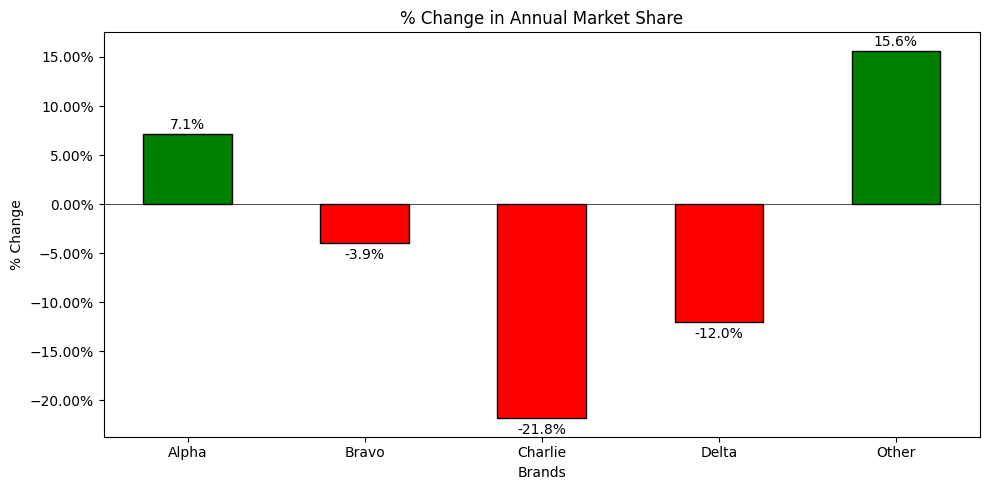

In [21]:
yoy_pct_change = market_share.pct_change().T[2]

n = 5
r = np.arange(n)
width = 0.5

plt.figure(figsize=(10,5))

for i, val in enumerate(yoy_pct_change):
    color = 'green' if val > 0 else 'red'
    plt.bar(r[i], val, width=width, color=color, edgecolor = 'black')
    plt.text(r[i], val + 0.002 if val > 0 else val - 0.005, 
             f"{val:.1%}", ha='center', va='bottom' if val > 0 else 'top', color='black')
    
plt.xticks(r,market_share.columns.values.tolist()) 
plt.gca().yaxis.set_major_formatter('{x:,.2%}')
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Brands')
plt.ylabel('% Change')
plt.title('% Change in Annual Market Share')
plt.tight_layout()
plt.show()

#### Average SKU Price

In [22]:
average_sku_prices = grocery_df[grocery_df['year'] == 1].groupby(['sku_id', 'brand'], observed=True)['price'].mean()
alpha_avg_sku_prices = average_sku_prices.xs('Alpha', level='brand')
style_series(alpha_avg_sku_prices, format_type='float', caption='Alpha - Average SKU price', header_name='Average Price ($)')

,Average Price ($)
sku_id,
10,10.49
11,2.27
12,2.79
14,1.99
15,3.42
16,2.58
17,2.80
18,3.27
19,2.62


In [23]:
alpha_avg_sku_prices.describe()

count    18.000000
mean      4.042794
std       2.947076
min       1.847050
25%       2.590040
50%       2.895911
75%       3.436983
max      12.430000
Name: price, dtype: float64

#### Garbage Collect

In [24]:
del market_share, group_year, yoy_pct_change, category_pct_change, axis_labels, grouped_spend
del grouped_volume, sku_df, yearly_sales, color, i, r, val, width, n, pct_volume, 
gc.collect()

14393

### Exploring Variation in Buyer Behaviour

The objective here is to explore how to perform the basic analyses that describe the variation we observe in buyer behaviour in a given time period. We will continue to work with the edible grocery dataset, exploring both purchase frequency and spend.

Before we can doing any analysis, we need to create some summary datasets. The first will summarise **how many times each panellist purchased each brand as well as in the category**. The second will summarise **how much each panellist spent on each brand and in the category**.

In [25]:
grocery_df[(grocery_df['panel_id'] == 3102016) & (grocery_df['trans_id'] == 844)]

,panel_id,trans_id,week,sku_id,units,price,brand,spend,weight,volume,year
11,3102016,844,4,5,1,3.49,Alpha,3.49,1000,1.0,1
12,3102016,844,4,5,1,3.49,Alpha,3.49,1000,1.0,1
13,3102016,844,4,5,1,3.49,Alpha,3.49,1000,1.0,1
14,3102016,844,4,15,1,3.49,Alpha,3.49,1000,1.0,1
15,3102016,844,4,15,1,3.49,Alpha,3.49,1000,1.0,1
16,3102016,844,4,89,1,2.49,Delta,2.49,1000,1.0,1


On this one shopping trip (`trans_id` = 844), panellist `3102021` purchased a total of six items: three packs of SKU 5, two packs of SKU 15, and one pack of SKU 89. They purchased two different brand, Alpha and Delta.

Why are three lines for SKU 5 and not one line with units = 3. This is simply a function of how the items were scanned at the checkout. Some checkout operators will scan the three items separately; this would result in three lines in the transaction file, each with units = 1. Others will scan the item and press “3” on their till, resulting in one line in the transaction file with units = 3.

By convention, this purchase occasion is recorded as one **category transaction**, one Alpha transaction, and one Delta transaction. The number of units of Alpha purchased is five. When we say that the panellist made one category transaction, we mean they purchased at least one item in the category on that shopping trip. When we say that the panellist made one Alpha transaction, we mean they purchased at least one item associated with the brand on that shopping trip.

In order to analyse buyer behaviour in terms of transactions, we need to know the **number of brand and category transactions for each person**. We cannot work directly with the dataset we have been using; we effectively need to collapse the five rows associated with Alpha into one. This will require some intermediate analysis, which we undertake in the following manner.

Result of the intermediate prep should produce a dataset that summarizes transaction 844 by panellist 3102016 as 1 occasion of Alpha brand purchase and 1 occasion of Delta brand purchase:
<div>
<img src="references\intermediate-data-prep.png" width="1000"/>
</div>

#### Panellist-level data preparation

**One row per transaction**, with a binary indicator of whether or not each brand was purchased.

In [26]:
# Filter for year == 1, group by transaction ID, panel ID and brand, then count unique panel_ids per transaction and brand
# Each panelist has done some number of transactions. Group unique transactions and obtain the count of transactions occasions in which any listed brand was purchased
# Note: this is not a sum of total units (by brand) purchased per panellist.
# Note: Because there are multiple entires for the same transaction ID, we are not doing a count of brand instance per panelist (without trans_id grouping) as this would duplicate the occasions in some cases.

# Produce a dataset where there is just one row per transaction, with a binary indicator of whether or not each brand was purchased.
# Create a new column to track category purchase. Each row is an instance of at least one brand purchase so category column is set to 1.
group_trans = (grocery_df[grocery_df['year'] == 1]).groupby(['trans_id', 'panel_id', 'brand'], observed=True)['panel_id'].nunique().astype('int16')
group_trans = group_trans.unstack(level='brand', fill_value=0)
group_trans['Category'] = 1
group_trans

,brand,Alpha,Bravo,Charlie,Delta,Other,Category
trans_id,panel_id,,,,,,
1,3102551,0,1,0,0,0,1
2,3102680,1,0,0,0,0,1
3,3102700,1,0,0,0,0,1
4,3102733,0,0,1,0,0,1
5,3102987,1,0,0,0,0,1
...,...,...,...,...,...,...,...
20026,3128382,0,1,0,0,0,1
20027,3128402,0,1,0,0,0,1
20028,3128539,0,1,0,0,0,1


**Panellist-level *transaction* summary**

Summarizes each panellist's purchase occasions (transactions) for each brand

In [27]:
# Count of brand purchase occasions (transactions) per panellist
group_trans = group_trans.groupby(level='panel_id').sum()
group_trans

brand,Alpha,Bravo,Charlie,Delta,Other,Category
panel_id,,,,,,
3102011,1,0,0,0,0,1
3102012,1,2,0,0,0,2
3102016,9,6,0,1,0,13
3102021,2,0,0,0,0,2
3102022,3,0,0,0,0,3
...,...,...,...,...,...,...
3128866,0,10,0,0,0,10
3128867,0,1,1,0,0,2
3128874,0,3,0,0,0,3


**Panellist-level *spend* summary**

Amount each panellist spent on each brand (and in the category) during year 1.

In [28]:
group_spend = (grocery_df[grocery_df['year'] == 1]).groupby(['panel_id', 'brand'], observed=True)['spend'].sum()
group_spend = group_spend.unstack(level='brand', fill_value=0)
group_spend['Category'] = group_spend.sum(axis=1)
group_spend

brand,Alpha,Bravo,Charlie,Delta,Other,Category
panel_id,,,,,,
3102011,2.790000,0.000000,0.00,0.00,0.0,2.790000
3102012,6.380000,18.650000,0.00,0.00,0.0,25.029999
3102016,67.800003,17.740000,0.00,2.49,0.0,88.029999
3102021,6.580000,0.000000,0.00,0.00,0.0,6.580000
3102022,8.930000,0.000000,0.00,0.00,0.0,8.930000
...,...,...,...,...,...,...
3128866,0.000000,30.639999,0.00,0.00,0.0,30.639999
3128867,0.000000,2.190000,2.23,0.00,0.0,4.420000
3128874,0.000000,10.260000,0.00,0.00,0.0,10.260000


**Panellist-level *volume purchasing* summary**

Summarises each panellist’s volume purchasing in year 1.

In [29]:
group_vol = (grocery_df[grocery_df['year'] == 1]).groupby(['panel_id', 'brand'], observed=True)['volume'].sum()
group_vol = group_vol.unstack(level='brand', fill_value=0)
group_vol['Category'] = group_vol.sum(axis=1)
group_vol

brand,Alpha,Bravo,Charlie,Delta,Other,Category
panel_id,,,,,,
3102011,0.5,0.0,0.0,0.0,0.0,0.5
3102012,2.0,5.0,0.0,0.0,0.0,7.0
3102016,19.1,5.5,0.0,1.0,0.0,25.6
3102021,2.0,0.0,0.0,0.0,0.0,2.0
3102022,1.9,0.0,0.0,0.0,0.0,1.9
...,...,...,...,...,...,...
3128866,0.0,10.5,0.0,0.0,0.0,10.5
3128867,0.0,0.5,1.0,0.0,0.0,1.5
3128874,0.0,3.0,0.0,0.0,0.0,3.0


Looking at panellist-level spend and panellist-level volume purchasing, we note that for each row Category equals the sum of the brand numbers, as we would expect. But this is not always the case in panellist-level transactions. Why is the sum of the brand-specific numbers sometimes greater than the associated category number?

Answer: Because a single transactions (once grouped) can have occasions of multiple brand purchases but the transaction only counts as one occasion of a category purchase. Consider the panellist `3102016` and her transaction ID `844`, The 4 entires on the one transaction count  as a single category transaction, a single Alpha brand transaction and a single Delta transaction. The category transaction count is not a sum of brand purchase transaction count because regardless of the brand(s) and quantities purchased, the panelist purchased the category once in that transaction only.

#### Examining Purchase Frequency

Two standard brand performance metrics that summarize purchasing behaviour are **penetration** and **purchases per buyer (PPB)**. 

- *Penetration* is the percentage of households buying the product/category at least once in the given time period. 
  - In order to compute this, we need to know the number of panellists buying the product at least once in the time period of interest and the size of the panel during this period.
- *Purchases per buyer (PPB)* is the average number of times (separate shopping trips) the product/category was purchased (in the given time period) by those households that made at least one product/category purchase (in the given time period).
  - i.e. purchases per buyer (PPB) is the average number of times the product was purchased (in the given time period) per buyer. 
  - This is computed as the total number of purchase occasions on which the product was purchased by the panellists (in the time period of interest) divided by the number of panellists that purchased the product at least once (in the time period of interest).

Looking at *panellist-level transaction summary*, we see that there are 4574 rows in this table, meaning that we have summary data on the purchasing of 4574 households in year 1. But there are 5021 households in the panel. What has happened to the remaining 447 households? They did not make any category purchase during the year. (But they will have purchased in other categories.)

In [30]:
# the number of panellists who purchased each brand at least once in year 1
buyers = group_trans.astype(bool).sum() # computed entries in each column that is greater than 1
style_series(buyers, format_type='int', caption='Number of Buyers in Year 1:', header_name='# Buyers')

,# Buyers
brand,
Alpha,"2,624"
Bravo,"2,562"
Charlie,813
Delta,380
Other,176
Category,"4,574"


In [31]:
# On how many purchase occasions did the brand/category buyers of each brand/category buy that brand/category?
# i.e, On how many purchase occasions did the 2624 buyers of Alpha buy Alpha?
transactions = group_trans.sum() # sum all entries in each column 

style_series(transactions, format_type='int', caption='Purchase occasions by buyers:', header_name='# Transactions')

,# Transactions
brand,
Alpha,"9,060"
Bravo,"8,255"
Charlie,"1,882"
Delta,859
Other,422
Category,"20,030"


In [32]:
panel_size = 5021

# Penetration is simply the number of brand buyers divided by the number of panellists, expressed as a percentage
penetration = buyers / panel_size
# Purchases per buyer (PPB) is simply to total number of purchases occasions divided by the number of buyers.
ppb = transactions / buyers

In [33]:
style_series(penetration, format_type='pct', caption='Penetration:', header_name='Penetration %')

,Penetration %
brand,
Alpha,52.3%
Bravo,51.0%
Charlie,16.2%
Delta,7.6%
Other,3.5%
Category,91.1%


In [34]:
style_series(ppb, format_type='float', caption='Purchases per buyer (PPB):', header_name='PPB')

,PPB
brand,
Alpha,3.45
Bravo,3.22
Charlie,2.31
Delta,2.26
Other,2.40
Category,4.38


We see that 91% of the households in the panel purchased in the category at least once in year 1. (This is a widely purchased product category.) On average, they purchased in the category 4.4 times that year. Looking at Alpha, we see that 52% of the households in the panel purchased the brand at least once, purchasing it on average 3.5 times.

Penetration and PPB are in fact summary measures of an important but frequently overlooked summary of buyer behaviour: the **distribution of purchase frequency**. We first explore how to create this summary of category purchasing and then consider how to create such a summary of brand purchasing.

#### Distribution of Category Purchase Frequency

Looking at the *panellist-level transaction summary*, the distribution of category purchasing is determined by counting how many households made one category purchase (panellists 3102011, 3102046, etc.), two category purchases (panellists 3102012, 3102021, etc.), and so on.

In [35]:
# Category Transaction Distribution
category_trans_dist = group_trans.groupby(['Category'])['Category'].count()
# Add zero purchase row to the top of the data series with a new column name 'Frequency'
zero_purchase_row = pd.Series([panel_size - category_trans_dist.sum()], index=[0])
category_trans_dist = pd.concat([zero_purchase_row, category_trans_dist]).to_frame(name='Frequency')
category_trans_dist.index.name = '# of Purchases'

# Add percentage of total column
category_trans_dist['% of Total'] = category_trans_dist['Frequency'] / category_trans_dist['Frequency'].sum()

style_series(category_trans_dist, format_type=['int', 'pct'], caption='Category Transaction Distribution', header_name='Frequency', df=True)

,Frequency,% of Total
# of Purchases,,
0,447,8.9%
1,667,13.3%
2,759,15.1%
3,757,15.1%
4,612,12.2%
5,514,10.2%
6,381,7.6%
7,247,4.9%
8,209,4.2%


If we wish to create a visual representation of this distribution, it is tempting to simply plot the data in % of total column. However, the resulting plot would be misleading as *some purchase frequencies are missing in the data*. In particular, we see that no one made *21 category purchases; ditto for 23, 24, and 26*. One solution is to insert manually the missing number of purchases levels with 0 frequencies and then plot the data. However, the observed (relative) frequencies in the right tail are so small that they do not show up in a plot. We can therefore create a **right-censored distribution**. Here we have chosen 15 as the (right) censoring point; we see that 51 households (or 1% of the panellists) made 15 or more category purchases in year 1.

There is nothing magical about our choice of 15. Generally, the choice of censoring point is a function of how many bins you wish to display and the height of the right-most bar with which you feel comfortable.

Note that while the right-censored distribution is useful when creating a summary figure or table, it is of limited value beyond that. For example, it is not possible to compute the **mean purchase frequency** (and therefore PPB) from this summary.

In [36]:
# Create a new dataframe for categories with 15 or more purchases (overflow bin)
overflow = category_trans_dist[category_trans_dist.index >= 15]
# Sum the frequencies and percentages for the overflow bin
overflow_total_freq = overflow['Frequency'].sum()
overflow_total_pct = overflow['% of Total'].sum()


# Create an overflow row with the combined data
overflow_row = pd.DataFrame({
    'Frequency': [overflow_total_freq],
    '% of Total': [overflow_total_pct]
}, index=['15+'])

# Remove the original 15+ rows from the main data and append the overflow row
category_trans_dist_overflow = category_trans_dist[category_trans_dist.index < 15]
category_trans_dist_overflow = pd.concat([category_trans_dist_overflow, overflow_row])

style_series(category_trans_dist_overflow, format_type=['int', 'pct'], caption='Category Transaction Distribution', header_name='Frequency', df=True)

,Frequency,% of Total
0,447,8.9%
1,667,13.3%
2,759,15.1%
3,757,15.1%
4,612,12.2%
5,514,10.2%
6,381,7.6%
7,247,4.9%
8,209,4.2%
9,127,2.5%


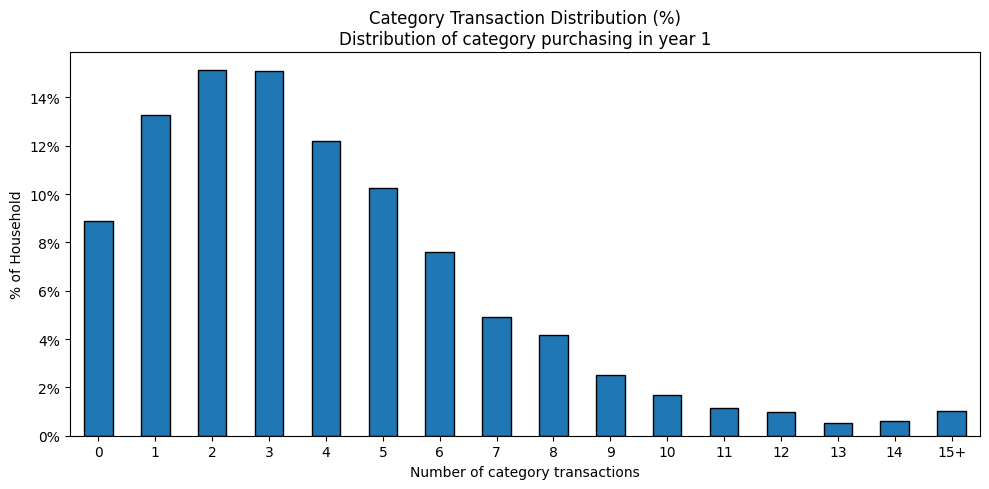

In [37]:
ax = category_trans_dist_overflow.plot.bar(y='% of Total', figsize=(10, 5), edgecolor = 'black')
ax.set_title('Category Transaction Distribution (%)\nDistribution of category purchasing in year 1')
ax.set_xlabel('Number of category transactions')
ax.set_ylabel('% of Household')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.legend().set_visible(False)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

We see that 9% of the panellists made no category purchases, 13% of the panellists made one category purchase, . . . , and 1% of the panellists made at least 15 category purchases in year 1.

#### The Relationship Between the Mean and PPB

What is the average number of times the category was purchased by a household in year 1?

- Recall that mean, which we denote by $E(X)$, is given by:
  - $$E(X)=\sum\frac{xf_{x}}{n}$$
  - where $f_{x}$ is the frequency with which $x$ occurs in the dataset, $n$ is the sample size, and the summation is over all possible values of $x$.
- Denoting the relative frequency with which $x$ occurs (i.e., $f_{x}/n$) by $P(X = x)$, the mean is given by:
  - $$E(X)=\sum x P(X = x)$$
  - More formally, we can say that $P(X = x)$ is the empirical probability that a randomly chosen household made $x$ purchases.

In [38]:
# Mean of the relative purchase frequency
mean = (category_trans_dist.index * category_trans_dist['% of Total']).sum()
print(f'{mean = :0.3f}')

mean = 3.989


We see that average number of category purchases is 4.0. Why is this different from the 4.4 purchases per buyer (PPB) computed above? The mean we have just computed *includes those households that made zero purchases*, whereas *PPB is the average among those households that made at least one* (in this case category) purchase.

We can derive the relationship between these two quantities (mean of the relative frequency and PPB) in the following manner:
$$
  \begin{aligned}
    PBB &= \sum_{x=1}^{\max x} \frac{xf_{x}}{n-f_{0}} \\
                   &= \sum_{x=0}^{\max x} \frac{xf_{x}}{n-f_{0}} \\
                   &= \sum_{x=0}^{\max x} \left(\frac{xf_{x}}{n-f_{0}}\right)\left(\frac{n}{n}\right) \\
                   &= \sum_{x=0}^{\max x} \left(\frac{xf_{x}}{n}\right)\left(\frac{n}{n-f_{0}}\right) \\
                   &= \left(\frac{n}{n-f_{0}}\right)\sum_{x=0}^{\max x} \left(\frac{xf_{x}}{n}\right) \\
                   &= \frac{E(X)}{1-P(X=0)}
  \end{aligned}
$$

In other words, **PPB is the mean divided by penetration**.

In [39]:
# All category PPB computations here are equivalent
ppb_category = mean / penetration['Category']
print(ppb_category)
print(ppb['Category'])
ppb_category = mean / (1 - category_trans_dist['% of Total'][0])
print(ppb_category)

4.379099256668124
4.379099256668124
4.379099256668124


#### Distribution of Brand Puchase Frequency

Let us now create the distribution of purchase frequency for Alpha, which is. With the one exception noted below, the logic follows that associated with creating the distribution of category purchasing.

In contrast to the `groupby` aggregation output associated with our summary of category purchasing, this aggregation does contain a zero category. However, we must be careful in our interpretation of the associated frequency. We see that 1950 category buyers did not buy Alpha in year 1. However, in order to have a complete summary of brand purchasing, we should also account for those 447 households that made no category purchases that year. The number of panellists making zero purchases of Alpha is the total number of panellists (5021) minus the number of panellists that made 1, 2, 3, . . . purchases.

**Note**: What is Alpha’s penetration of category buyers? (1 − 1950/4574) = 57%.
- Category Penetration = (1 - % of category buyers who did not purchase the brand)

In [40]:
# Alpha Brand Transaction Distribution
alpha_trans_dist = group_trans.groupby(['Alpha'])['Alpha'].count()
# Calculate zero purchases by subtracting the total sum of all purchases from the full panel size
zero_purchase_row = pd.Series([panel_size - alpha_trans_dist.sum()], index=[0]) # This ensures all panelists who made zero purchases are accounted for
# Concatenate zero_purchase_row with alpha_trans_dist
alpha_trans_dist = pd.concat([zero_purchase_row, alpha_trans_dist]).to_frame(name='Frequency')
# Combine any duplicate 0 purchase entries
alpha_trans_dist = alpha_trans_dist.groupby(alpha_trans_dist.index).sum()

# Add a '% of Total' column
alpha_trans_dist['% of Total'] = alpha_trans_dist['Frequency'] / panel_size

style_series(alpha_trans_dist, format_type=['int', 'pct'], caption='Alpha Transaction Distribution', header_name='Frequency', df=True)

,Frequency,% of Total
0,"2,397",47.7%
1,733,14.6%
2,517,10.3%
3,400,8.0%
4,277,5.5%
5,227,4.5%
6,144,2.9%
7,101,2.0%
8,71,1.4%
9,47,0.9%


In [41]:
# Create a new dataframe for Alpha with 10 or more purchases (overflow bin)
overflow = alpha_trans_dist[alpha_trans_dist.index >= 10]
# Sum the frequencies and percentages for the overflow bin
overflow_total_freq = overflow['Frequency'].sum()
overflow_total_pct = overflow['% of Total'].sum()


# Create an overflow row with the combined data
overflow_row = pd.DataFrame({
    'Frequency': [overflow_total_freq],
    '% of Total': [overflow_total_pct]
}, index=['10+'])

# Remove the original 15+ rows from the main data and append the overflow row
alpha_trans_dist_overflow = alpha_trans_dist[alpha_trans_dist.index < 10]
alpha_trans_dist_overflow = pd.concat([alpha_trans_dist_overflow, overflow_row])

style_series(alpha_trans_dist_overflow, format_type=['int', 'pct'], caption='Alpha Transaction Distribution', header_name='Frequency', df=True)

,Frequency,% of Total
0,"2,397",47.7%
1,733,14.6%
2,517,10.3%
3,400,8.0%
4,277,5.5%
5,227,4.5%
6,144,2.9%
7,101,2.0%
8,71,1.4%
9,47,0.9%


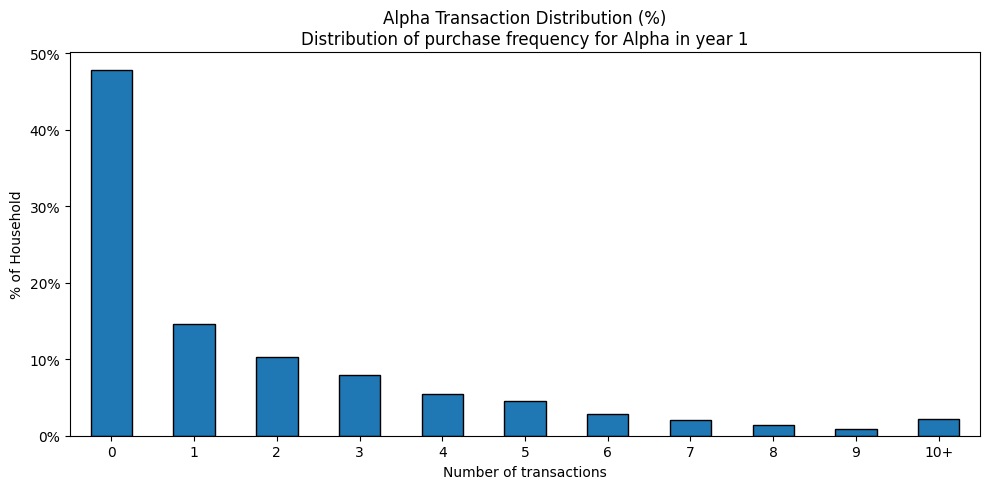

In [42]:
ax = alpha_trans_dist_overflow.plot.bar(y='% of Total', figsize=(10, 5), edgecolor = 'black')
ax.set_title('Alpha Transaction Distribution (%)\nDistribution of purchase frequency for Alpha in year 1')
ax.set_xlabel('Number of transactions')
ax.set_ylabel('% of Household')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.legend().set_visible(False)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Distribution of Spend

##### Distribution of Category Spend

We now turn our attention to creating summaries of total spend. Our initial goal is to create a histogram of category spend (in dollars) across those panellists that made at least one purchase in the category in year 1. In the following plot, the raw total spend data have been binned in bins with a width of $5. 

We see that 16% of category buyers spent up to $5 in the category during this one-year period; 23% spent between $5 and $10; . . . and 2% spent more than $50.

In [43]:
category_spend = group_spend.groupby(['panel_id'])['Category'].sum()
category_spend

panel_id
3102011     2.790000
3102012    25.029999
3102016    88.029999
3102021     6.580000
3102022     8.930000
             ...    
3128866    30.639999
3128867     4.420000
3128874    10.260000
3128878    34.400002
3128880     3.380000
Name: Category, Length: 4574, dtype: float32

Before deciding on what bin width to use when creating the histogram, let us first compute some basic descriptive statistics.

In [44]:
category_spend.describe()

count    4574.000000
mean       15.763423
std        12.876024
min         1.270000
25%         6.760000
50%        12.570000
75%        20.737500
max       166.699997
Name: Category, dtype: float64

There appears to be quite a bit of variability in category spend. To get further insight into the distribution of total category spend across the panellists, we need to determine the total spend quantities associate with the various percentile levels.

In [45]:
percentiles = np.arange(5, 96, 5)
# np.percentile returns the k-th percentile of values in a range
percentile_values = np.percentile(category_spend, percentiles)

percentile_df = pd.DataFrame(data=percentile_values, 
                             index=percentiles, 
                             columns=['Value'])
percentile_df.index.name = 'Percentile Level'

style_series(percentile_df, format_type='float', caption='Percentiles', header_name='Value', df=True)

,Value
Percentile Level,
5,2.69
10,3.39
15,4.67
20,5.88
25,6.76
30,7.63
35,9.07
40,10.06
45,11.03


We see that 5% of the category buyers spent $2.69 or less in the category during the year, 10% spent $3.39 or less, and so on. The heaviest 5% of buyers each spent more than $39.72 in the category during the year.

Looking out this output, we conclude that a bin size of $5 is probably about right.

How many bins do we go with? This is an empirical question. Since 5% of the panel spent more than $39.72, we certainly want to go above $40 in order to get a sense of how they are spread between $39.72 and the maximum of $166.70. We will go with $50. If too many panellists have spent more than $50, we can always add more bins. If too few panellists fall into this bin, we can always combine the bins we have created.

In [46]:
# Define bins, adding np.inf as the upper bound to capture all values above 50
bins = np.append(np.arange(0, 51, 5), np.inf)

# Apply pd.cut to categorize 'category_spend' with the new bins
category_labels = pd.cut(category_spend, bins=bins, include_lowest=True, right=False)

# Group by the new bins and calculate the sum
category_spend = category_spend.groupby(category_labels, observed=False).count()

category_spend

Category
[0.0, 5.0)       750
[5.0, 10.0)     1073
[10.0, 15.0)     882
[15.0, 20.0)     623
[20.0, 25.0)     450
[25.0, 30.0)     256
[30.0, 35.0)     192
[35.0, 40.0)     123
[40.0, 45.0)      68
[45.0, 50.0)      48
[50.0, inf)      109
Name: Category, dtype: int64

We see that 750 panellists spent $5 or less in the category during year 1, 1073 spent between $5 and $10, . . . , and 109 spent more than $50.

We convert the raw counts into percentages and plot these percentages as a bar chart.

In [47]:
category_spend_pct = category_spend / category_spend.sum()
category_spend_pct

Category
[0.0, 5.0)      0.163970
[5.0, 10.0)     0.234587
[10.0, 15.0)    0.192829
[15.0, 20.0)    0.136205
[20.0, 25.0)    0.098382
[25.0, 30.0)    0.055969
[30.0, 35.0)    0.041976
[35.0, 40.0)    0.026891
[40.0, 45.0)    0.014867
[45.0, 50.0)    0.010494
[50.0, inf)     0.023830
Name: Category, dtype: float64

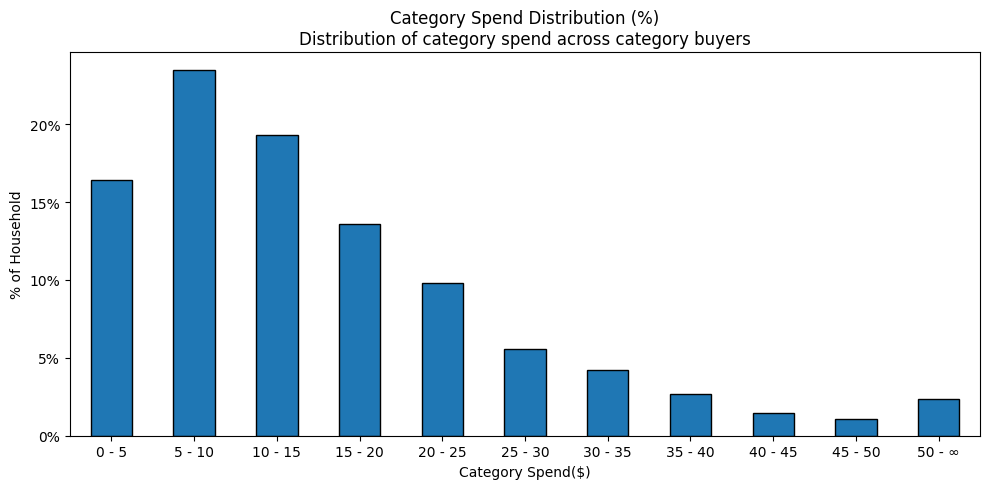

In [48]:
x_labels = [f"{int(interval.left)} - {int(interval.right) if interval.right != np.inf else '∞'}" for interval in category_spend.index]
ax = category_spend_pct.plot.bar(x=x_labels, y='% of Total', figsize=(10, 5), edgecolor = 'black')
ax.set_title('Category Spend Distribution (%)\nDistribution of category spend across category buyers')
ax.set_xlabel('Category Spend($)')
ax.set_ylabel('% of Household')
ax.set_xticklabels(x_labels, rotation=0)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.legend().set_visible(False)
plt.tight_layout()
plt.show()

The general shape of this distribution (i.e., an interior mode, median less than the mean, right-skewed with a long right-tail) is what we typically observe when we look at spend data.

This, of course, depends on the bin width we choose when summarising the data. If we had chosen a bin width of $10, the left-most bar would be the highest bar and we would no longer observe an interior mode.

##### Distribution of Brand Spend

Let us now create the distribution of spend on Alpha. We will follow the same basic process as for the distribution of category spend with a few minor changes.

Note that there are a number of 0 or NaN values in the Alpha spend column. While these panellists purchased in the category during the year, they did not purchase any of Alpha’s SKUs. The first thing we need to do is remove these observations.

In [49]:
alpha_spend = group_spend.groupby(['panel_id'])['Alpha'].sum() 
alpha_spend = alpha_spend[alpha_spend > 0] # Remove $0 spend rows
alpha_spend

panel_id
3102011     2.790000
3102012     6.380000
3102016    67.800003
3102021     6.580000
3102022     8.930000
             ...    
3128845     2.450000
3128849     2.450000
3128861    15.920000
3128878    34.400002
3128880     3.380000
Name: Alpha, Length: 2624, dtype: float32

In [50]:
alpha_spend.describe()

count    2624.000000
mean       12.793802
std        11.715617
min         1.570000
25%         3.690000
50%         9.670000
75%        17.130000
max       105.900002
Name: Alpha, dtype: float64

In [51]:
percentiles = np.arange(5, 96, 5)
percentile_values = np.percentile(alpha_spend, percentiles)

percentile_df = pd.DataFrame(data=percentile_values, 
                             index=percentiles, 
                             columns=['Value'])
percentile_df.index.name = 'Percentile Level'

style_series(percentile_df, format_type='float', caption='Percentiles', header_name='Value', df=True)

,Value
Percentile Level,
5,2.45
10,2.79
15,3.38
20,3.49
25,3.69
30,5.48
35,6.58
40,6.88
45,7.67


Having looked at some basic descriptive stats (as above), we will summarise the data using bins of width $2, right-censoring at $40.

In [52]:
bins = np.append(np.arange(0, 41, 2), np.inf)
alpha_labels = pd.cut(alpha_spend, bins=bins, include_lowest=True, right=False)
alpha_spend = alpha_spend.groupby(alpha_labels, observed=False).count()
alpha_spend

Alpha
[0.0, 2.0)       61
[2.0, 4.0)      633
[4.0, 6.0)      148
[6.0, 8.0)      363
[8.0, 10.0)     154
[10.0, 12.0)    236
[12.0, 14.0)    199
[14.0, 16.0)     88
[16.0, 18.0)    141
[18.0, 20.0)     72
[20.0, 22.0)    102
[22.0, 24.0)     82
[24.0, 26.0)     48
[26.0, 28.0)     43
[28.0, 30.0)     27
[30.0, 32.0)     49
[32.0, 34.0)     30
[34.0, 36.0)     18
[36.0, 38.0)     23
[38.0, 40.0)     18
[40.0, inf)      89
Name: Alpha, dtype: int64

In [53]:
alpha_spend_pct = alpha_spend / alpha_spend.sum()
alpha_spend_pct

Alpha
[0.0, 2.0)      0.023247
[2.0, 4.0)      0.241235
[4.0, 6.0)      0.056402
[6.0, 8.0)      0.138338
[8.0, 10.0)     0.058689
[10.0, 12.0)    0.089939
[12.0, 14.0)    0.075838
[14.0, 16.0)    0.033537
[16.0, 18.0)    0.053735
[18.0, 20.0)    0.027439
[20.0, 22.0)    0.038872
[22.0, 24.0)    0.031250
[24.0, 26.0)    0.018293
[26.0, 28.0)    0.016387
[28.0, 30.0)    0.010290
[30.0, 32.0)    0.018674
[32.0, 34.0)    0.011433
[34.0, 36.0)    0.006860
[36.0, 38.0)    0.008765
[38.0, 40.0)    0.006860
[40.0, inf)     0.033918
Name: Alpha, dtype: float64

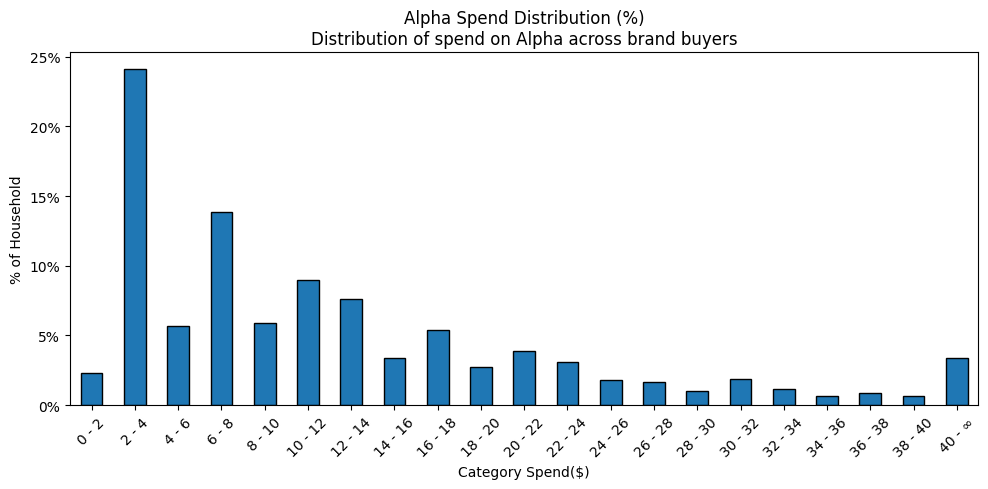

In [54]:
x_labels = [f"{int(interval.left)} - {int(interval.right) if interval.right != np.inf else '∞'}" for interval in alpha_spend.index]
ax = alpha_spend_pct.plot.bar(x=x_labels, y='% of Total', figsize=(10, 5), edgecolor = 'black')
ax.set_title('Alpha Spend Distribution (%)\nDistribution of spend on Alpha across brand buyers')
ax.set_xlabel('Category Spend($)')
ax.set_ylabel('% of Household')
ax.set_xticklabels(x_labels, rotation=45)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.legend().set_visible(False)
plt.tight_layout()
plt.show()

The general observation made earlier about category spend distribution about the shape of the distribution of spend holds. It is not so smooth, but this is a function of the smaller bins sizes. There is, however, one obvious aberration—the large spike for \$2–\$4. What is going on here? The average price of most Alpha SKUs is between \$2 and \$4. (Review average SKU prices of Alpha) We recall from Alpha's distribution of purchase frequency plot that 48% of the panel made zero purchases of Alpha and 15% made one transaction. This implies that 0.15/(1 − 0.48) = 29% of Alpha buyers made just one purchase of the brand. Assuming they only purchased only one unit of one Alpha SKU on that purchase occasion, we would expect a large number of Alpha buyers to spend between \$2 and \$4; 24% is not unrealistic.

How would you determine the validity of the assumption that the buyers who purchased Alpha just once mostly bought only one unit of Alpha SKU on that purchase occasion?

##### Analyzing Alpha's One-Time Buyers in Year 1

From our distribution of brand purchase frequency analysis, we can see that 733 buyers purchased Alpha brand products only once. In other words, the 733 buyers only had a single occasion in which they purchased Alpha brand products. Additionally, from our distribution of Alpha brand spend, we can see that 633 of all types of Alpha buyers brought within a spend range of \$2 to \$4. 

Using the panellist-level transaction summary, we filter for panel IDs that only have a single count of Alpha brand purchase occasion (transactions). 

In [70]:
# One-Time Alpha Buyers
one_time_alpha_buyers = group_trans[group_trans['Alpha'] == 1]['Alpha']
one_time_alpha_buyers

panel_id
3102011    1
3102012    1
3102069    1
3102085    1
3102094    1
          ..
3128834    1
3128843    1
3128845    1
3128849    1
3128880    1
Name: Alpha, Length: 733, dtype: int16

In [71]:
# Alpha buyers who spent between $2 to $4
spend_range_alpha_buyers = group_spend[
    (group_spend['Alpha'] >= 2) & 
    (group_spend['Alpha'] < 4)
]['Alpha']
spend_range_alpha_buyers

panel_id
3102011    2.79
3102069    2.69
3102094    3.69
3102156    3.29
3102163    3.19
           ... 
3128834    2.29
3128843    2.45
3128845    2.45
3128849    2.45
3128880    3.38
Name: Alpha, Length: 633, dtype: float32

In [57]:
res = one_time_alpha_buyers[one_time_alpha_buyers.index.isin(spend_range_alpha_buyers.index)].count()

print(f'There are {res} one-time Alpha buyers who spent between [$2, $4).')
print(f'Given that there are {spend_range_alpha_buyers.count()} Alpha buyers in total who spent between $2-$4,\nthe {res} one-time buyers represent {res / spend_range_alpha_buyers.count():.0%} of the Alpha buyers in that spend range.')

There are 623 one-time Alpha buyers who spent between [$2, $4).
Given that there are 633 Alpha buyers in total who spent between $2-$4,
the 623 one-time buyers represent 98% of the Alpha buyers in that spend range.


**Validate**:

In [81]:
spend_range_alpha_buyers[spend_range_alpha_buyers.index.isin(one_time_alpha_buyers.index)].sum()

1937.23

In [82]:
grocery_df[
    (grocery_df['year'] == 1) &
    (grocery_df['panel_id'].isin(spend_range_alpha_buyers.index)) &
    (grocery_df['panel_id'].isin(one_time_alpha_buyers.index)) &
    (grocery_df['brand'] == 'Alpha')
]['spend'].sum()

1937.23